In [0]:
#import the required libraries
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [0]:
# Download the dataset and put them in folder
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  # download annotation zip file
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  # Store them in proper folder
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
else:
  annotation_file = '/content/annotations/captions_train2014.json'

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [0]:
# Read the json file that is just stored
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
captions = []
name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    name_vector.append(full_coco_image_path)
    captions.append(caption)

# Shuffle captions and image_names together and Set a random state
train_captions, img_name_vector = shuffle(captions,
                                          name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_ex = 30000
train_captions = train_captions[:num_ex]
img_name_vector = img_name_vector[:num_ex]

In [4]:
len(train_captions), len(captions)

(30000, 414113)

In [0]:
# Preprocess the image using inception model's preprocessing technique
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [0]:
# Use Tensorflow's inception model 
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [0]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Set the image parameteres
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_words = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_words,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [0]:
# Create training and validation sets using an 70-30 split
img_train, img_val, caption_train, caption_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.3,
                                                                    random_state=0)

In [15]:
len(img_train), len(caption_train), len(img_val), len(caption_val)

(21000, 21000, 9000, 9000)

In [0]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_words + 1
num_steps = len(img_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [0]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_train, caption_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
class Create_Model(tf.keras.Model):
  def __init__(self, units):
    super(Create_Model, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = Create_Model(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    x = self.fc1(output)

    x = tf.reshape(x, (-1, x.shape[2]))

    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_model(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [28]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_model(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 5 Batch 0 Loss 0.3472
Epoch 5 Batch 100 Loss 0.2993
Epoch 5 Batch 200 Loss 0.2981
Epoch 5 Batch 300 Loss 0.2772
Epoch 5 Loss 0.315268
Time taken for 1 epoch 391.3785102367401 sec

Epoch 6 Batch 0 Loss 0.3205
Epoch 6 Batch 100 Loss 0.3160
Epoch 6 Batch 200 Loss 0.2699
Epoch 6 Batch 300 Loss 0.2728
Epoch 6 Loss 0.296272
Time taken for 1 epoch 299.88956665992737 sec

Epoch 7 Batch 0 Loss 0.3015
Epoch 7 Batch 100 Loss 0.2704
Epoch 7 Batch 200 Loss 0.2790
Epoch 7 Batch 300 Loss 0.2540
Epoch 7 Loss 0.281295
Time taken for 1 epoch 323.80388736724854 sec

Epoch 8 Batch 0 Loss 0.2859
Epoch 8 Batch 100 Loss 0.2411
Epoch 8 Batch 200 Loss 0.2572
Epoch 8 Batch 300 Loss 0.2457
Epoch 8 Loss 0.257399
Time taken for 1 epoch 320.2311980724335 sec

Epoch 9 Batch 0 Loss 0.2790
Epoch 9 Batch 100 Loss 0.2552
Epoch 9 Batch 200 Loss 0.2430
Epoch 9 Batch 300 Loss 0.2302
Epoch 9 Loss 0.242981
Time taken for 1 epoch 318.64584040641785 sec

Epoch 10 Batch 0 Loss 0.2701
Epoch 10 Batch 100 Loss 0.2350
Epoch 1

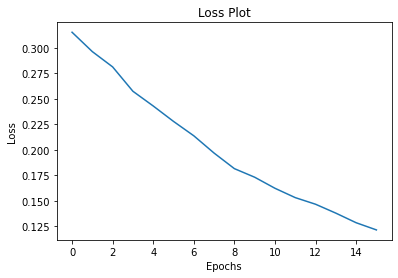

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
def Evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_result(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> four cows with long fur <unk> a winter snow <end>
Prediction Caption: two animals that is walking across a line <end>


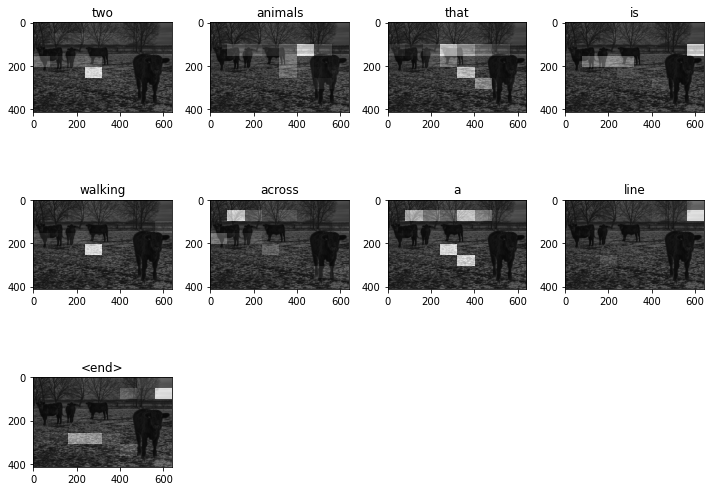

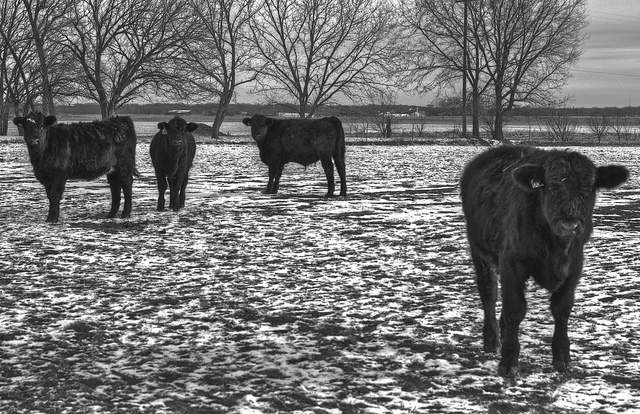

In [35]:
# captions on the validation set
rid = np.random.randint(0, len(img_val))
image = img_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_val[rid] if i not in [0]])
result, attention_plot = Evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_result(image, result, attention_plot)
# image_path = tf.keras.utils.get_file('image',
                                    #  origin=image)
Image.open(image)


  98304/Unknown - 0s 1us/stepPrediction Caption: a beach with chairs and black boats and an umbrella and on a beach one beach with umbrella and some people <end>


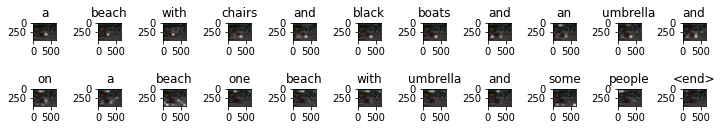

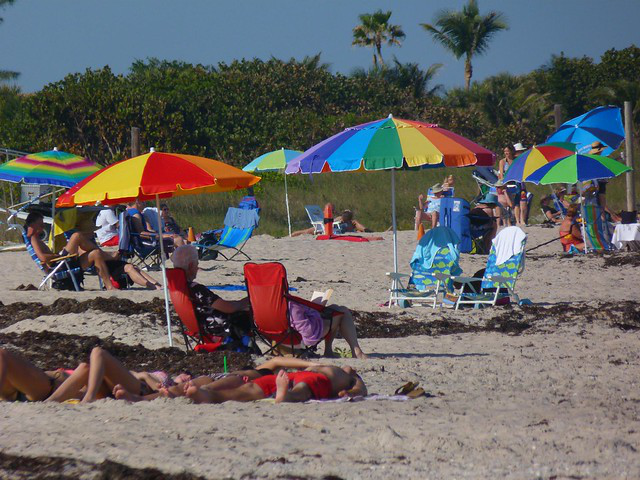

In [36]:
image_url = 'https://farm8.staticflickr.com/7145/6667086759_5d610c7571_z.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image',
                                     origin=image_url)

result, attention_plot = Evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_result(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
)